# ****Final Project Submission****


- Student name: Scott Johnson
- Student pace: Part Time
- Scheduled project review date/time: 2/19/2021
- Instructor name: Amanda Yandow
 
# Project Title: Modeling Census Data for COVID-19 Stimulus Checks

Build a classifier to predict whether a citizen should recieve a stimulus check based on having and income over/under 50K. Lessons learned from data set can be recylced to improve predictions after initial stimulus is delivered to those in neeed.
Outline:

1. Data cleaning and preprocessing
2. EDA
3. Split/Train DataSet
4. Feature Engineering
5. Modeling and Evaluatioin
6. Model evaluating
7. Choosing final model

In [1]:
!export PATH=/Library/TeX/texbin:$PATH

## 1. Data Cleaning and Preprocessing

Import Packages and Data

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

#SCIKIT LEARN
#Scikit-learn is a machine learning toolkit that provides various tools to cater to different aspects of machine
#learning e.g. Classification, Regression, Clustering, Dimensionality reduction, Model selection, Preprocessing.
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score,confusion_matrix, recall_score, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

#train test split
from sklearn.model_selection import train_test_split

#k-fold cross validation
from sklearn.model_selection import cross_val_score

#PICKLE for saving objects
import pickle

# Install a pip package in the current Jupyter kernel

import sys
!{sys.executable} -m pip install imblearn

from imblearn.over_sampling import SMOTE

# Pretty display for notebooks
%matplotlib inline

/Users/scojopro/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
#Load Dataset
income_df = pd.read_csv("income_evaluation.csv")

# print the shape
print('The shape of the dataset : ', income_df.shape)

#Take a look at first 10 rows
income_df.head(10)

The shape of the dataset :  (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [4]:
income_copy_df = income_df.copy()

In [5]:
## Convert column names to python format with underscores instead of spaces or dashes

income_copy_df.columns = income_df.columns.str.strip().str.replace('-', '_')
income_copy_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [8]:
income_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Looks like we have 9 objects, 6 integer types. However, considering our future purpose, we have 6 continuous variables and 9 categorical variables. See below for what they represent:

#### Continuous Attributes

- age: continuous. **Age of an individual**
- education-num: number of education year, continuous. --> **Individual's year of receiving education**
- fnlwgt: final weight, continuous. --> **The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau.**
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous. --> **Individual's working hour per week**


#### Categorical Attributes
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked --> **Individual work category**
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. --> **Individual's highest education degree**
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. --> **Individual marital status**
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. --> **Individual's occupation**
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. --> **Individual's relation in a family**
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. --> **Race of Individual**
- sex: Female, Male.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. --> **Individual's native country**

Based on the first iteration of this project, we're going to drop columns that are redundant or we don't think will particularly useful in our final outcome:

- fnlwgt 
- education (duplicate of education number)
- native country
- race
- sex 

In [10]:
income_copy_df = income_copy_df.drop(columns= ['fnlwgt', 'education', 'fnlwgt', 'native_country', 'race'])
income_copy_df.columns

Index(['age', 'workclass', 'education_num', 'marital_status', 'occupation',
       'relationship', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
       'income'],
      dtype='object')

### Check for missing data and placeholders.

In [11]:
print(income_copy_df.shape)
income_copy_df.isna().sum()

(32561, 11)


age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
income            0
dtype: int64

In [12]:
#check for place holders

for column in income_copy_df:
    #Select column contents by column name using [] operator
    columnSeriesdf = income_copy_df[column]
    print('Column : ', column)
    print('Contents : ', columnSeriesdf.unique())

Column :  age
Contents :  [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
Column :  workclass
Contents :  [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Column :  education_num
Contents :  [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Column :  marital_status
Contents :  [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Column :  occupation
Contents :  [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
Column :  relationship
Contents :  [' Not-in-family' ' 

We can see, even though we don't have any null values, we do have ? placeholders. So let's separate our variables into to categorical and continous and then we'll get decide what to do with the ?'s.

In [13]:
categorical = [var for var in income_copy_df.columns if income_copy_df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 6 categorical variables

The categorical variables are :

 ['workclass', 'marital_status', 'occupation', 'relationship', 'sex', 'income']


In [14]:
continuous = [var for var in income_copy_df.columns if income_copy_df[var].dtype!='O']

print('There are {} continuous variables\n'.format(len(continuous)))

print('The continuous variables are :\n\n', continuous)

There are 5 continuous variables

The continuous variables are :

 ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


Let's now deal with the ?'s in our categorical variables. Let's first check their frequency percentage.

In [15]:
for var in categorical:
    
     print(income_copy_df[var].value_counts()/np.float(len(income_copy_df)))

 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: workclass, dtype: float64
 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837
 Married-AF-spouse        0.000706
Name: marital_status, dtype: float64
 Prof-specialty       0.127146
 Craft-repair         0.125887
 Exec-managerial      0.124873
 Adm-clerical         0.115783
 Sales                0.112097
 Other-service        0.101195
 Machine-op-inspct    0.061485
 ?                    0.056601
 Transport-moving     0.049046
 Handlers-cleaners    0.042075
 Farming-fishing      0.030527
 Tech-support         0.028500
 Protective-serv      0.019932
 Priv-house-s

We will replace the ? with NaN so Python can detect the nulls.

In [16]:
income_copy_df['workclass'].replace(' ?', np.NaN, inplace=True)
income_copy_df['occupation'].replace(' ?', np.NaN, inplace=True)

In [17]:
for var in categorical:
    
     print(income_copy_df[var].value_counts()/np.float(len(income_copy_df)))

 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name: workclass, dtype: float64
 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837
 Married-AF-spouse        0.000706
Name: marital_status, dtype: float64
 Prof-specialty       0.127146
 Craft-repair         0.125887
 Exec-managerial      0.124873
 Adm-clerical         0.115783
 Sales                0.112097
 Other-service        0.101195
 Machine-op-inspct    0.061485
 Transport-moving     0.049046
 Handlers-cleaners    0.042075
 Farming-fishing      0.030527
 Tech-support         0.028500
 Protective-serv      0.019932
 Priv-house-serv      0.004576
 Armed-Forces         0.000276
Name: occupa

## 2. Exploratory Data Analysis

Now that we've cleaned up our data. Let's take a look at some of the key things we can learn:

- 25% of sampled population makes over 50k a year, while the other 75% makes under or equal to 50k
- If we wanted to take a shot in the dark, the 75% who would likely need the stimulus check also happen to have an average age of 36 years old and younger,
- none of our continous variables seem to be highly correlated, though education level seems to be slightly correlated with capital gains and # of daily hours worked 
- if we wanted a way to focus our efforts to distribute stimulus money just based on the data alone, we could focus on those who work for private companies, as the majority of those individuals are more likely to be at risk than at other agencies

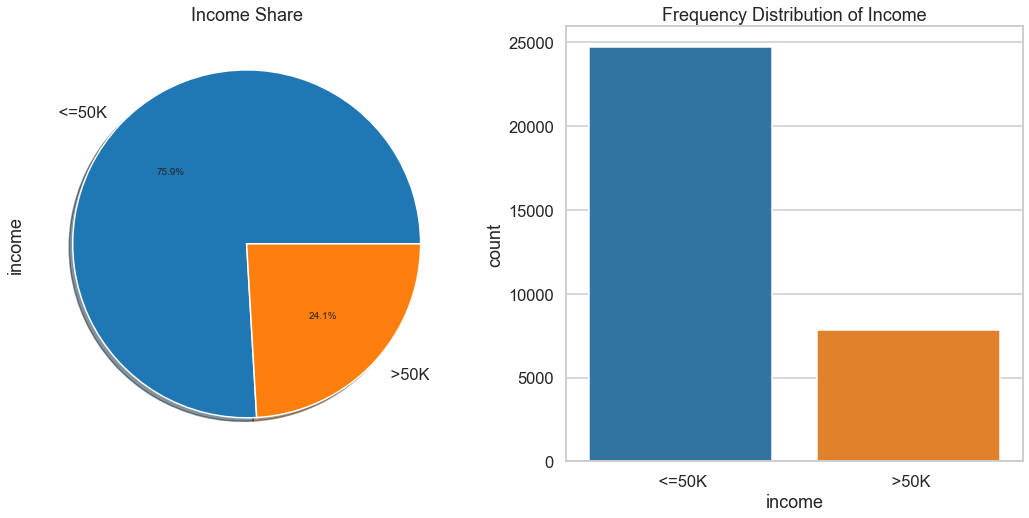

In [20]:
# visualize frequency distribution of income variable
f,ax=plt.subplots(1,2,figsize=(18,8))

ax[0] = income_copy_df['income'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Income Share')

#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="income", data=income_copy_df)
ax[1].set_title("Frequency Distribution of Income")

plt.show()

We can see that 24.1% of the people in our data set make above 50k and 75% make equal to or below 50k.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd386f27128>,
      dtype=object)

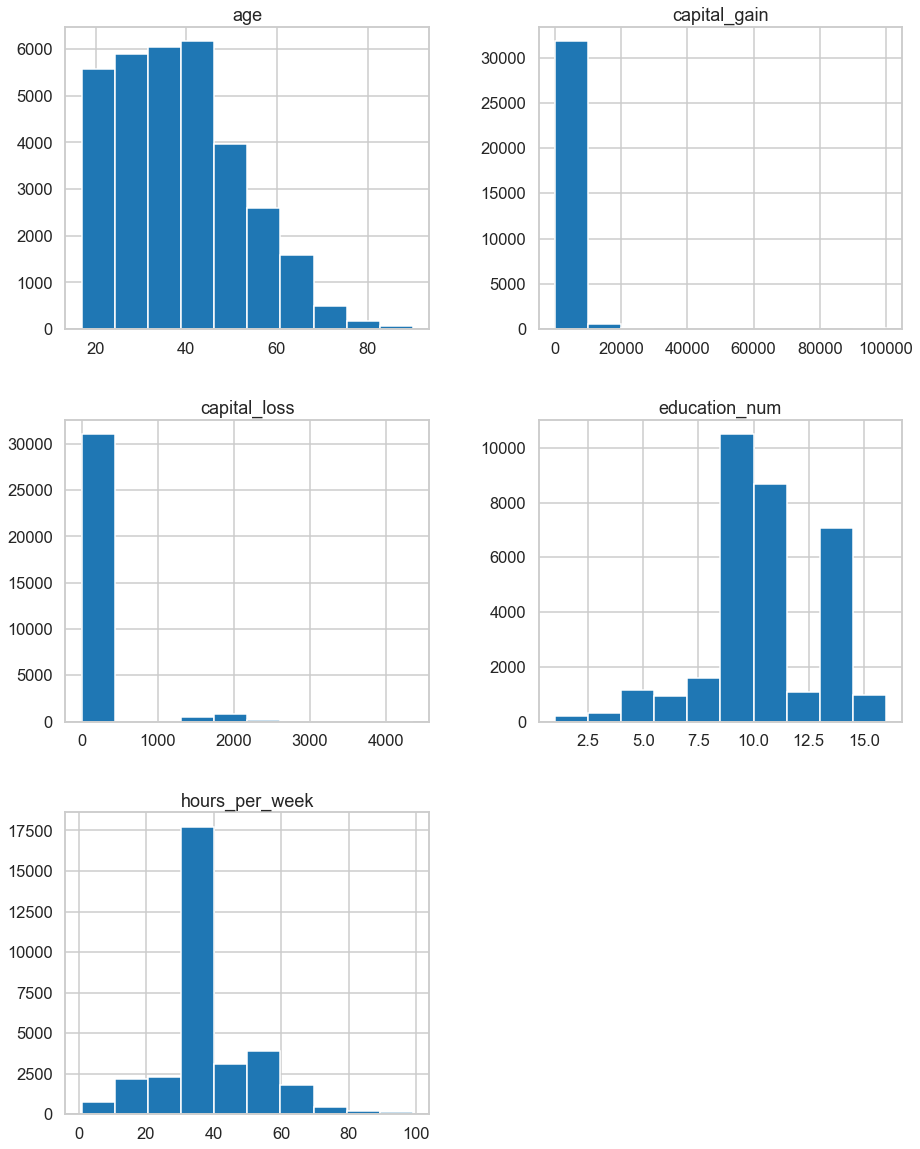

In [22]:
#plots for continuous variables
income_copy_df.hist(figsize = (15, 20))

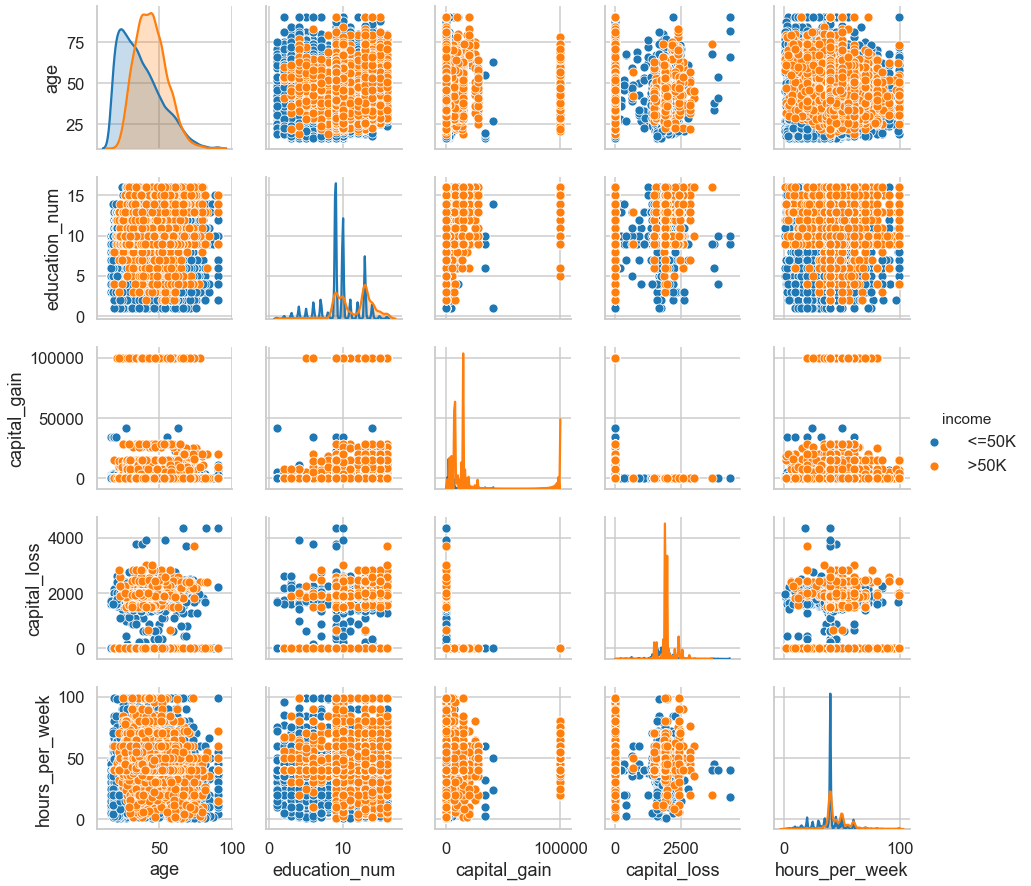

In [23]:
sns.pairplot(income_copy_df, hue="income")

### Correlation Matrix

Though not significantly high, the most notably correlated values are between the education number and the numbers of hours and captial gain. Are the hardest workers better educated?

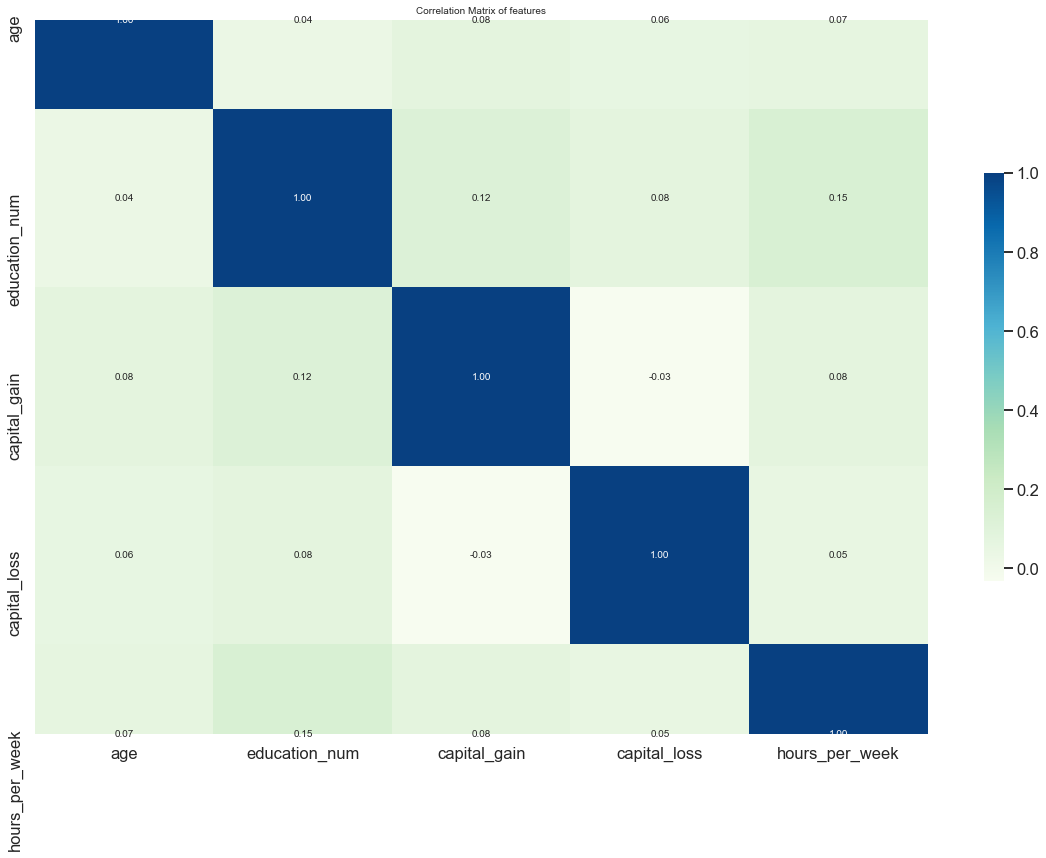

In [24]:
correlation_matrix = income_copy_df.corr()
plt.figure(figsize=(20, 15))
ax = sns.heatmap(
    correlation_matrix,
    vmax=1,
    square=True,
    annot=True,
    fmt='.2f',
    cmap='GnBu',
    cbar_kws={"shrink": .5},
    robust=True)
plt.title('Correlation Matrix of features', fontsize=10)
plt.show()

In [26]:
## Let's find out if there are discrepancies between average ages.
income_copy_df.groupby(['income'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24720.0,36.783738,14.020088,17.0,25.0,34.0,46.0,90.0
>50K,7841.0,44.249841,10.519028,19.0,36.0,44.0,51.0,90.0


Generally the average age of individuals who make above 50K seem to be 44 and older. So in terms of priority, the stimulus checks should prioritize a younger crowd. Based on age alone, if you would capture the same percentage of the population that would benefit from stimulus checks.

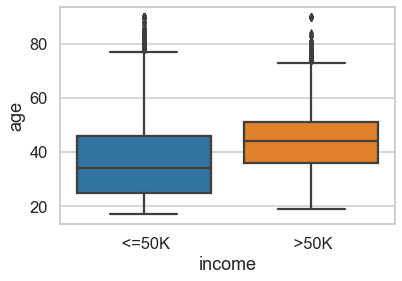

In [27]:
sns.boxplot(x='income', y='age', data=income_copy_df)

Other trends include a higher average hours per week worked by those who make over 50K and a higher education number.

In [29]:
income_copy_df.groupby(['income'])['hours_per_week'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24720.0,38.840210,12.318995,1.0,35.0,40.0,40.0,99.0
>50K,7841.0,45.473026,11.012971,1.0,40.0,40.0,50.0,99.0


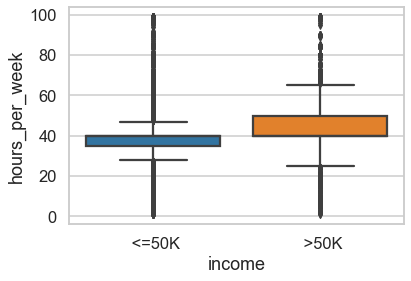

In [28]:
sns.boxplot(x='income', y='hours_per_week', data=income_copy_df)

In [31]:
income_copy_df.groupby(['income'])['education_num'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24720.0,9.595065,2.436147,1.0,9.0,9.0,10.0,16.0
>50K,7841.0,11.611657,2.385129,2.0,10.0,12.0,13.0,16.0


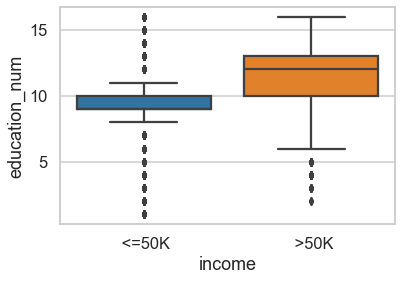

In [30]:
sns.boxplot(x='income', y='education_num', data=income_copy_df)

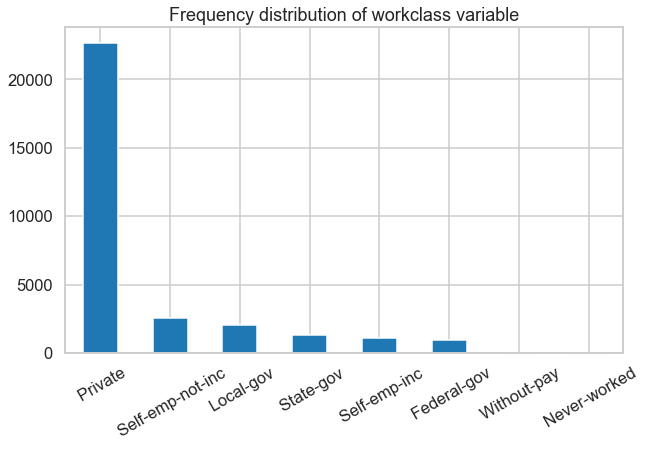

In [32]:
f, ax = plt.subplots(figsize=(10, 6))
ax = income_copy_df.workclass.value_counts().plot(kind="bar")
ax.set_title("Frequency distribution of workclass variable")
ax.set_xticklabels(income_copy_df.workclass.value_counts().index, rotation=30)
plt.show()

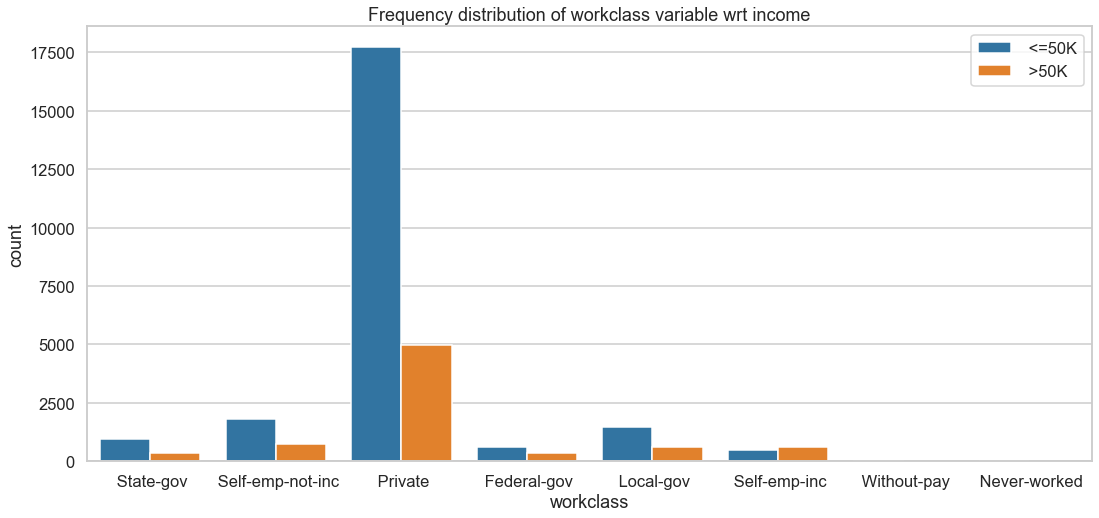

In [33]:
f, ax = plt.subplots(figsize=(18, 8))
ax = sns.countplot(x="workclass", hue="income", data=income_copy_df)
ax.set_title("Frequency distribution of workclass variable wrt income")
ax.legend(loc='upper right')
plt.show()

In [316]:
income_copy_df.groupby(['income'])['capital_gain'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
0,24720.0,148.752468,963.139307,0.0,0.0,0.0,0.0,41310.0
1,7841.0,4006.142456,14570.378951,0.0,0.0,0.0,0.0,99999.0


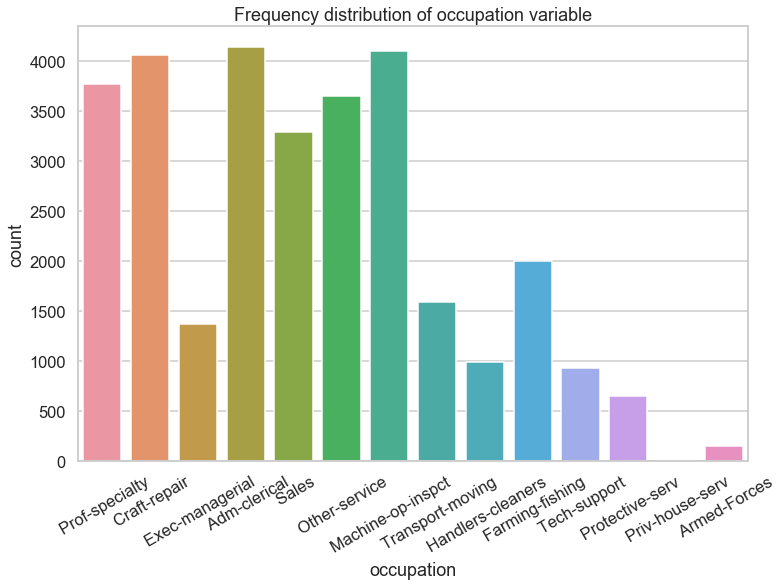

In [34]:
# visualize frequency distribution of `occupation` variable

f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x="occupation", data=income_copy_df)
ax.set_title("Frequency distribution of occupation variable")
ax.set_xticklabels(income_copy_df.occupation.value_counts().index, rotation=30)
plt.show()

## 3. Feature Engineering

Let's move on to Feature Engineering. We need to first engineer a replacement for the now null values that were changed from ? to NaN. Afterward we'll use LabelEncoder to encode the categorical variables.

In [35]:
#Seperate out categorical and numeric/continuous variables so that we can make sure all necessary changes are resolved.
categorical = []
numeric = []
for c in income_copy_df.columns:
    if income_copy_df[c].dtypes == 'object':
        categorical.append(c)
    else:
        numeric.append(c)
        
categorical, numeric

(['workclass',
  'marital_status',
  'occupation',
  'relationship',
  'sex',
  'income'],
 ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'])

In [36]:
income_copy_df[categorical].isnull().mean()

workclass         0.056386
marital_status    0.000000
occupation        0.056601
relationship      0.000000
sex               0.000000
income            0.000000
dtype: float64

Though we relabeled our null categorical values as NaN, we still have to decide what to do with them. For workclass, occupation, and native_country, they account for less than 10 percent of the data, but still represent thousands of people, we won't delete them. Instead we'll impute the missing values with the most frequent (or the mode). We'll need to do this for both X_train and X_test.

In [38]:
for x in [income_copy_df]:
    x['workclass'].fillna(income_copy_df['workclass'].mode()[0], inplace=True)
    x['occupation'].fillna(income_copy_df['occupation'].mode()[0], inplace=True) 

In [39]:
income_copy_df[categorical].isnull().mean()

workclass         0.0
marital_status    0.0
occupation        0.0
relationship      0.0
sex               0.0
income            0.0
dtype: float64

In [40]:
income_copy_df.head()

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,<=50K


In [41]:
#Change Income column to numeric values
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
income_copy_df.income = labelencoder.fit_transform(income_copy_df.income)

In [42]:
income_copy_df.income

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

In [43]:
#One hot encoding
income_copy_df = pd.get_dummies(income_copy_df)
income_copy_df.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,53,7,0,0,40,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [44]:
income_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 43 columns):
age                                      32561 non-null int64
education_num                            32561 non-null int64
capital_gain                             32561 non-null int64
capital_loss                             32561 non-null int64
hours_per_week                           32561 non-null int64
income                                   32561 non-null int64
workclass_ Federal-gov                   32561 non-null uint8
workclass_ Local-gov                     32561 non-null uint8
workclass_ Never-worked                  32561 non-null uint8
workclass_ Private                       32561 non-null uint8
workclass_ Self-emp-inc                  32561 non-null uint8
workclass_ Self-emp-not-inc              32561 non-null uint8
workclass_ State-gov                     32561 non-null uint8
workclass_ Without-pay                   32561 non-null uint8
marital_status_ Divorce

In [53]:
income_copy_df.to_csv('one_hot_income_evaluation.csv')

TypeError: to_csv() got an unexpected keyword argument 'index_col'

## 4. Train, Test, Split After Setting Target variable -->> try 80/20 and try SMOTE --> both to address class imbalance

In [60]:
income_base = pd.read_csv('one_hot_income_evaluation.csv')
income_base = income_base.drop(columns=['Unnamed: 0'])
income_base.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,53,7,0,0,40,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,28,13,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [61]:
cols = income_base.columns
cols

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital_status_ Divorced', 'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupatio

In [62]:
##feature vector
X = income_base.drop(['income'], axis=1)
X.head()


,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,53,7,0,0,40,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [63]:
##target
y = income_base['income']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

In [64]:
# creating a list of different datasets and their train/test data
x_train_list= list()
y_train_list= list()
x_test_list= list()
y_test_list= list()

In [65]:
## 70/30 split
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.3, random_state = 0)

# get the dimenssion of each ub dataframe
print(X_train_1.shape)
print(y_train_1.shape)
print(X_test_1.shape)
print(y_test_1.shape)

# add train and test data to the list
x_train_list.append(X_train_1)
y_train_list.append(y_train_1)
x_test_list.append(X_test_1)
y_test_list.append(y_test_1)

(22792, 42)
(22792,)
(9769, 42)
(9769,)


In [66]:
## 80/20 split
from sklearn.model_selection import train_test_split

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.2, random_state = 0)

# get the dimenssion of each ub dataframe
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

# add train and test data to the list
x_train_list.append(X_train_2)
y_train_list.append(y_train_2)
x_test_list.append(X_test_2)
y_test_list.append(y_test_2)

(26048, 42)
(26048,)
(6513, 42)
(6513,)


Look for and address Class imbalance:

0    24720
1     7841
Name: income, dtype: int64


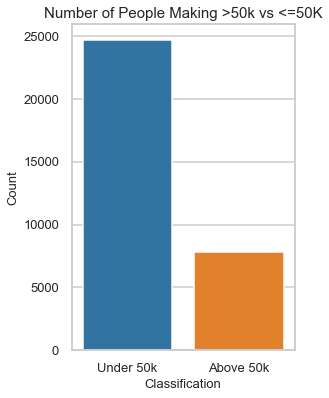

In [69]:
# for the original data before splitting
x = income_base.drop(columns = 'income')
y = income_base.income
print(y.value_counts())

plt.figure(figsize=(4,6))
sns.countplot(y)

plt.xticks(size = 13)
plt.yticks(size = 13)

plt.title('Number of People Making >50k vs <=50K', size = 15)

positions = (0,1)
labels = ("Under 50k","Above 50k")
plt.xticks(positions, labels)

plt.xlabel('Classification', size = 13)
plt.ylabel('Count', size = 13);

0    17313
1     5479
Name: income, dtype: int64


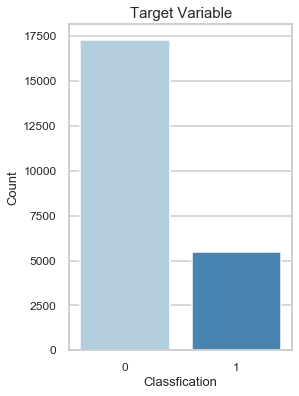

In [71]:
#training data imbalance for 70/30 split
print(y_train_1.value_counts())

plt.figure(figsize=(4,6))
sns.countplot(y_train_1, palette='Blues')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Target Variable', size = 15)
plt.xlabel('Classfication', size = 13)
plt.ylabel('Count', size = 13);

Use **SMOTE (Synthestic Minority Oversampling Technique)** or ADSYN (Adaptive Synthetic Sampling) to synthesize new samples from the minority class. With more time, I can include this to improve the perfomance of my model.

In [67]:
# a for loop to apply SMOTE on each dataset in the list of train and tests: 
#for training data:
#import imblearn
from imblearn.over_sampling import SMOTE, ADASYN

x_trainb_list= list()
y_trainb_list= list()

for i in range(2):
    x_train_balanced, y_train_balanced = SMOTE().fit_sample(x_train_list[i], y_train_list[i])
    print("dataset: ",i)
    print(y_train_list[i].value_counts())
    print("balanced")
    print(pd.Series(y_train_balanced).value_counts(), "\n") 
    
    #new balanced features and target data
    x_trainb = pd.DataFrame(x_train_balanced, columns = x_train_list[i].columns)
    y_trainb = y_train_balanced
    
    # add the balanced training data for all 4 datasets into the list
    x_trainb_list.append(x_trainb)
    y_trainb_list.append(y_trainb)

dataset:  0
0    17313
1     5479
Name: income, dtype: int64
balanced
1    17313
0    17313
dtype: int64 

dataset:  1
0    19802
1     6246
Name: income, dtype: int64
balanced
1    19802
0    19802
dtype: int64 



In [68]:
print(x_train_list[0].shape)
print(y_train_list[0].shape)
print(x_trainb_list[0].shape)
print(y_trainb_list[0].shape)

(22792, 42)
(22792,)
(34626, 42)
(34626,)


In [75]:
y_train_list[0].head()

32098    1
25206    0
23491    1
12367    0
7054     0
Name: income, dtype: int64

Currently we should have the following:

1. x_train_list[0], y_train_list[0] [70/30]
2. x_train_list[1], y_train_list[1] [80/20]
3. x_trainb_list[0], y_trainb_list[0] [70/30] with SMOTE
4. x_trainb_list[1], y_trainb_list[1] [80/20] with SMOTE

In [76]:
cols = x_train_list[0].columns
cols

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital_status_ Divorced', 'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-su

In [77]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

x_train70 = scaler.fit_transform(x_train_list[0])
x_train80 = scaler.fit_transform(x_train_list[1])
x_train70_smt = scaler.fit_transform(x_trainb_list[0])
x_train80_smt = scaler.fit_transform(x_trainb_list[1])

x_test70 = scaler.transform(x_test_list[0])
x_test80 = scaler.transform(x_test_list[1])

In [97]:
#Vectors
x_train70 = pd.DataFrame(x_train70, columns=[cols])
x_train80 = pd.DataFrame(x_train80, columns=[cols])
x_train70_smt = pd.DataFrame(x_train70_smt, columns=[cols])
x_train80_smt = pd.DataFrame(x_train80_smt, columns=[cols])
x_test70 = pd.DataFrame(x_test70, columns=[cols])
x_test80 = pd.DataFrame(x_test80, columns=[cols])

##Target columns
y_train70 = y_train_list[0]
y_train80 = y_train_list[1]
y_train70_smt = y_trainb_list[0]
y_train80_smt = y_trainb_list[1]
y_test70 = y_test_list[0]
y_test80 = y_test_list[1]

In [143]:
x_train70_smt.head()

,Unnamed: 0,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0,0.277778,-0.25,7298.0,0.0,2.222222,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.388889,-0.25,1831.0,0.0,-0.222222,0.0,0.0,0.0,-1.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
2,2,0.444444,0.00,0.0,0.0,1.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-0.611111,-0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-0.944444,-1.50,0.0,0.0,-1.666667,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
y_train_1.head()

32098    1
25206    0
23491    1
12367    0
7054     0
Name: income, dtype: int64

In [98]:
##Export X_train, X_test
x_train70.to_csv('x_train70.csv')
x_train80.to_csv('x_train80.csv')
x_train70_smt.to_csv('x_train70_smt.csv')
x_train80_smt.to_csv('x_train80_smt.csv')
x_test70.to_csv('x_test70.csv')
x_test80.to_csv('x_test80.csv')

### Export y_train (original), and y_test
pickle_out = open('y_train70.pickle', 'wb')
pickle.dump(y_train70, pickle_out)

pickle_out = open('y_train80.pickle', 'wb')
pickle.dump(y_train80, pickle_out)

pickle_out = open('y_train70_smt.pickle', 'wb')
pickle.dump(y_train70_smt, pickle_out)

pickle_out = open('y_train80_smt.pickle', 'wb')
pickle.dump(y_train80_smt, pickle_out)

pickle_out = open('y_test70.pickle', 'wb')
pickle.dump(y_test70, pickle_out)

pickle_out = open('y_test80.pickle', 'wb')
pickle.dump(y_test80, pickle_out)

## Model 1 Random Forest Classifier Model + Evaluation

Some of the conclusions of this model are that the default parameters 10 trees work best so far, giving :

- Precision: 0.9927508584509729
- Accuracy: 0.9862671112671113
- Recall: 0.9498083591896331
- F1: 0.9708049622236731

however, the cross validation was a moderate 0.73.

The accuracy was lower with 5 and 100 trees 0.79 and 0.82 -> 0.84 cross val respectively.

It also suggest that the most important features are age, education_num, marital status, number of hours worked per week, capital_gain.

In [148]:
#Import library just in case you want to start from here
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

In [149]:
#Get training data + test data

#X train
x_train70 = pd.read_csv('x_train70.csv').drop(columns=['Unnamed: 0'])
x_train80 = pd.read_csv('x_train80.csv').drop(columns=['Unnamed: 0'])
x_train70_smt = pd.read_csv('x_train70_smt.csv').drop(columns=['Unnamed: 0'])
x_train80_smt = pd.read_csv('x_train80_smt.csv').drop(columns=['Unnamed: 0'])
x_test70 = pd.read_csv('x_test70.csv').drop(columns=['Unnamed: 0'])
x_test80 = pd.read_csv('x_test80.csv').drop(columns=['Unnamed: 0'])

#Y Train
y_train70 =pickle.load(open('y_train70.pickle', 'rb'))
y_train80 =pickle.load(open('y_train80.pickle', 'rb'))
y_train70_smt =pickle.load(open('y_train70_smt.pickle', 'rb'))
y_train80_smt =pickle.load(open('y_train80_smt.pickle', 'rb'))
y_test70 = pickle.load(open('y_test70.pickle', 'rb'))
y_test80 = pickle.load(open('y_test80.pickle', 'rb'))

In [151]:
x_train70.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.40,-0.333333,7298.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.50,-0.333333,1831.0,0.0,-0.4,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
2,0.55,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.40,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,-2.000000,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
#creating a confusion matrix template
import warnings
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 5]

# from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [153]:
RandF_def70 = RandomForestClassifier(n_jobs=-1);
RandF_def80 = RandomForestClassifier(n_jobs=-1);
RandF_def70_smt = RandomForestClassifier(n_jobs=-1);
RandF_def80_smt = RandomForestClassifier(n_jobs=-1);

RandF_def70.fit(x_train70, y_train70);
RandF_def80.fit(x_train80, y_train80);
RandF_def70_smt.fit(x_train70_smt, y_train70_smt);
RandF_def80_smt.fit(x_train80_smt, y_train80_smt);

In [154]:
RandF_def70.decision_path(x_train70);
RandF_def80.decision_path(x_train80);
RandF_def70_smt.decision_path(x_train70_smt);
RandF_def80_smt.decision_path(x_train80_smt);

Performance for 70-30

Confusion Matrix, without normalization
[[17057   256]
 [  587  4892]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17313
           1       0.95      0.89      0.92      5479

    accuracy                           0.96     22792
   macro avg       0.96      0.94      0.95     22792
weighted avg       0.96      0.96      0.96     22792

roc_auc_score: 0.9390385423455438


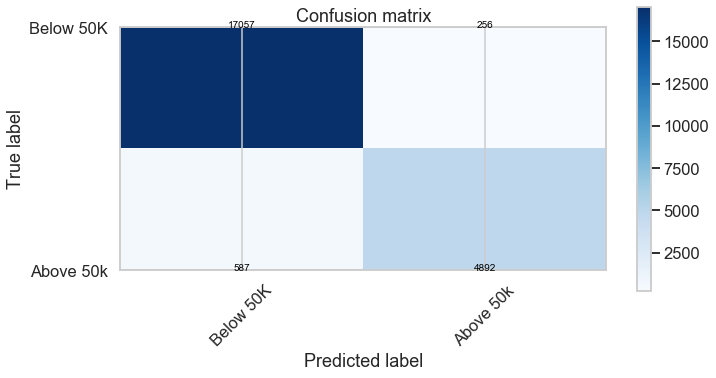

In [158]:
y_pred70_def_train = RandF_def70.predict(x_train70)

cm_def70 = confusion_matrix(y_train70, y_pred70_def)
classes = ['Below 50K', 'Above 50k']
plot_confusion_matrix(cm_def70, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_train70, y_pred70_def))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_train70, y_pred70_def))

In [159]:
print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_train70, y_pred70_def_train), 
                accuracy_score(y_train70, y_pred70_def_train), 
                recall_score(y_train70, y_pred70_def_train), 
                f1_score(y_train70, y_pred70_def_train)))


Precision: 0.9502719502719502
Accuracy: 0.963013338013338
Recall: 0.8928636612520533
F1: 0.920673755528371


In [160]:
scoreRFtrain70 = cross_val_score(RandF_def70, x_train70, y_train70, cv=5, scoring= 'precision')
print(scoreRFtrain70)
print(np.average(scoreRFtrain70))

[0.71153846 0.72246696 0.68443051 0.69400631 0.70682303]
0.7038530541548838


#### **Fit to Test Data**

In [161]:
y_pred70_def = RandF_def70.predict(x_test70)
y_probs70_def = RandF_def70.predict_proba(x_test70)

In [185]:
print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_test70,y_pred70_def), 
                accuracy_score(y_test70,y_pred70_def), 
                recall_score(y_test70,y_pred70_def), 
                f1_score(y_test70,y_pred70_def)))

Precision: 0.8886894075403949
Accuracy: 0.8025386426451019
Recall: 0.20956816257408975
F1: 0.33915724563206573


In [163]:
##cross validation score for fit
scoreRFtest70 = cross_val_score(RandF_def70, x_test70, y_test70, cv=5, scoring= 'precision')
print(scoreRFtest70)
print(np.average(scoreRFtest70))

[0.6868932  0.71919771 0.74603175 0.69620253 0.71144279]
0.7119535950733704


Confusion Matrix, without normalization
[[7345   62]
 [1867  495]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      7407
           1       0.89      0.21      0.34      2362

    accuracy                           0.80      9769
   macro avg       0.84      0.60      0.61      9769
weighted avg       0.82      0.80      0.75      9769

roc_auc_score: 0.6005988510993845


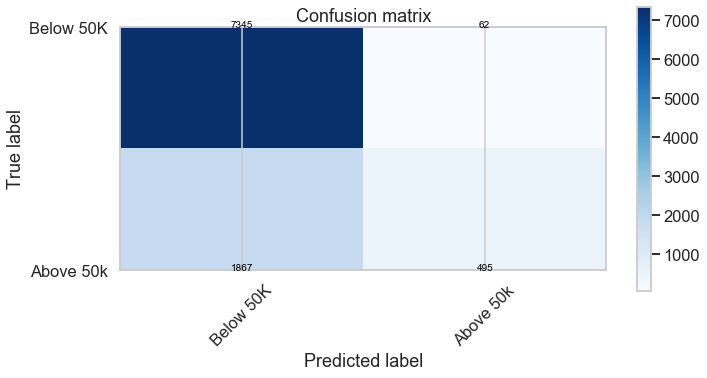

In [164]:
cm_RandF70 = confusion_matrix(y_test70, y_pred70_def)
classes = ['Below 50K', 'Above 50k']
plot_confusion_matrix(cm_RandF70, classes,
                      normalize=False,
                      title='Confusion matrix')
#Checking performance our model with classification report.
print(classification_report(y_test70, y_pred70_def))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test70, y_pred70_def))

Low roc-auc on the predicted model suggest the model isn't performing particular well in distinguishing between postive and negative classes.



Let's now test the performance on our other data sets.

In [165]:
y_pred70_smt_def = RandF_def70_smt.predict(x_test70)
y_pred80_def = RandF_def80.predict(x_test80)
y_pred80_smt_def = RandF_def80_smt.predict(x_test80)

#y_pred70_smt_def = RandF_def70_smt.predict_proba(x_test70)

In [166]:
# 70_smt
print ('precision:', precision_score(y_test70, y_pred70_smt_def))
print ('accuracy score:', RandF_def70_smt.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_pred70_smt_def))
print ('f1:', f1_score(y_test70, y_pred70_smt_def))
print ('roc_auc_score:', roc_auc_score(y_test70, y_pred70_smt_def))

precision: 0.6697009102730819
accuracy score: 0.8387757191114751
recall: 0.6541066892464014
f1: 0.6618119511672734
roc_auc_score: 0.7756155155426012


In [167]:
scoreRFtest70_smt = cross_val_score(RandF_def70_smt, x_test70, y_test70, cv=5, scoring= 'precision')
print(scoreRFtest70_smt)
print(np.average(scoreRFtest70_smt))

[0.6763285  0.71671388 0.7164557  0.6773399  0.70117647]
0.6976028903407776


Confusion Matrix, without normalization
[[6645  762]
 [ 817 1545]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      7407
           1       0.67      0.65      0.66      2362

    accuracy                           0.84      9769
   macro avg       0.78      0.78      0.78      9769
weighted avg       0.84      0.84      0.84      9769



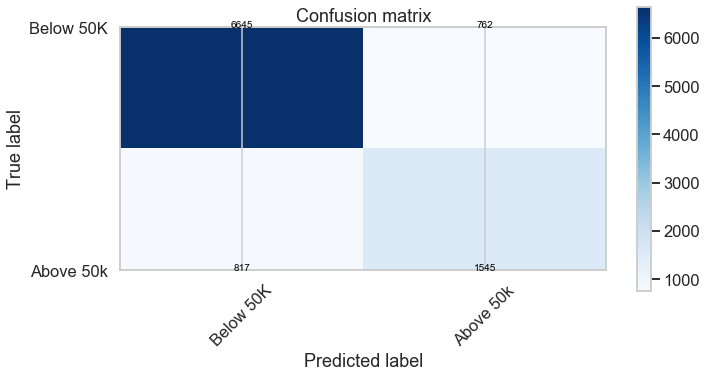

In [169]:
cm_RandF70_smt = confusion_matrix(y_test70, y_pred70_smt_def)
classes = ['Below 50K', 'Above 50k']
plot_confusion_matrix(cm_RandF70_smt, classes,
                      normalize=False,
                      title='Confusion matrix')
#Checking performance our model with classification report.
print(classification_report(y_test70, y_pred70_smt_def))
#Checking performance our model with ROC Score.

In [170]:
# 80
print ('precision:', precision_score(y_test80, y_pred80_def))
print ('accuracy score:', RandF_def80.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_pred80_def))
print ('f1:', f1_score(y_test80, y_pred80_def))
print ('roc_auc_score:', roc_auc_score(y_test80, y_pred80_def))

precision: 0.8797653958944281
accuracy score: 0.7948717948717948
recall: 0.18808777429467086
f1: 0.30991735537190085
roc_auc_score: 0.589875526024928


In [171]:
scoreRFtest80 = cross_val_score(RandF_def80, x_test80, y_test80, cv=5, scoring= 'precision')
print(scoreRFtest80)
print(np.average(scoreRFtest80))

[0.68531469 0.68301887 0.75308642 0.72932331 0.67330677]
0.7048100108342686


In [172]:
# 80_smt
print ('precision:', precision_score(y_test80, y_pred80_smt_def))
print ('accuracy score:', RandF_def80_smt.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_pred80_smt_def))
print ('f1:', f1_score(y_test80, y_pred80_smt_def))
print ('roc_auc_score:', roc_auc_score(y_test80, y_pred80_smt_def))

precision: 0.6643533123028391
accuracy score: 0.8350990327038231
recall: 0.6601880877742947
f1: 0.6622641509433962
roc_auc_score: 0.776007016640299


In [173]:
scoreRFtest80_smt = cross_val_score(RandF_def80_smt, x_test80, y_test80, cv=5, scoring= 'precision')
print(scoreRFtest80_smt)
print(np.average(scoreRFtest80_smt))

[0.71180556 0.68725869 0.73469388 0.71111111 0.69662921]
0.7082996889919041


Find Important Features

In [175]:
feature_scores_70 = pd.Series(RandF_def70.feature_importances_, index=x_train70.columns).sort_values(ascending=False)
feature_scores_70_smt = pd.Series(RandF_def70_smt.feature_importances_, index=x_train70_smt.columns).sort_values(ascending=False)
feature_scores_80 = pd.Series(RandF_def80.feature_importances_, index=x_train80.columns).sort_values(ascending=False)
feature_scores_80_smt = pd.Series(RandF_def80_smt.feature_importances_, index=x_train80_smt.columns).sort_values(ascending=False)

In [179]:
## Cycle through feature scores to see differences of weights in each model
feature_scores_80

age                                      0.239363
education_num                            0.145879
hours_per_week                           0.126489
capital_gain                             0.117046
marital_status_ Married-civ-spouse       0.075913
relationship_ Husband                    0.048592
capital_loss                             0.036106
marital_status_ Never-married            0.031561
occupation_ Exec-managerial              0.019886
sex_ Female                              0.018354
relationship_ Not-in-family              0.010692
workclass_ Private                       0.009928
occupation_ Prof-specialty               0.009457
workclass_ Self-emp-not-inc              0.009382
occupation_ Other-service                0.008904
occupation_ Sales                        0.007429
occupation_ Craft-repair                 0.006982
relationship_ Wife                       0.006805
workclass_ Federal-gov                   0.005978
occupation_ Tech-support                 0.005937


### Random Forest Classification with max_Depth=4, n_estimators=100

In [192]:
RandF_def70_dif = RandomForestClassifier(max_depth=4, random_state=3, n_jobs=-1, n_estimators=100)
RandF_def70_dif.fit(x_train70, y_train70);
RandF_def70_smt_dif = RandomForestClassifier(max_depth=4, random_state=3, n_jobs=-1, n_estimators=100)
RandF_def70_smt_dif.fit(x_train70_smt, y_train70_smt);

Confusion Matrix, without normalization
[[7407    0]
 [2287   75]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      7407
           1       1.00      0.03      0.06      2362

    accuracy                           0.77      9769
   macro avg       0.88      0.52      0.46      9769
weighted avg       0.82      0.77      0.67      9769

roc_auc_score: 0.5158763759525825
precision: 1.0
accuracy score: 0.7658921076875832
recall: 0.03175275190516511
f1: 0.061551087402544113


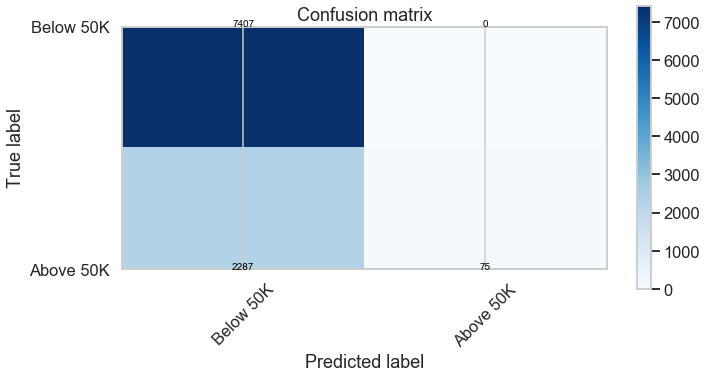

In [193]:
y_pred70_diff_def = RandF_def70_dif.predict(x_test70)

cm = confusion_matrix(y_test70, y_pred70_diff_def)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_test70, y_pred70_diff_def))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test70, y_pred70_diff_def))
print ('precision:', precision_score(y_test70, y_pred70_diff_def))
print ('accuracy score:', RandF_def70_dif.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_pred70_diff_def))
print ('f1:', f1_score(y_test70, y_pred70_diff_def))


In [195]:
scoreRF_diff = cross_val_score(RandF_def70_dif, x_test70, y_test70, cv=5, scoring= 'precision')
np.average(scoreRF_diff)

0.8345676861807695

Confusion Matrix, without normalization
[[5114 2293]
 [ 319 2043]]
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      7407
           1       0.47      0.86      0.61      2362

    accuracy                           0.73      9769
   macro avg       0.71      0.78      0.70      9769
weighted avg       0.83      0.73      0.75      9769

roc_auc_score: 0.7776864677176212
precision: 0.4711715867158672
accuracy score: 0.7326236052820145
recall: 0.8649449618966977
f1: 0.6100328456255599


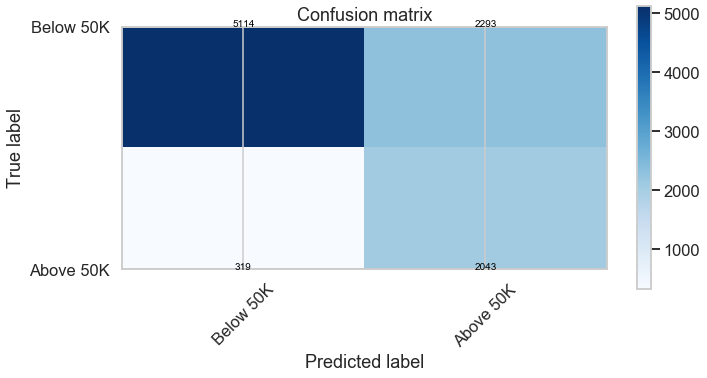

In [194]:
y_pred70_smt_diff_def = RandF_def70_smt_dif.predict(x_test70)
cm1 = confusion_matrix(y_test70, y_pred70_smt_diff_def)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm1, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_test70, y_pred70_smt_diff_def))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test70, y_pred70_smt_diff_def))
print ('precision:', precision_score(y_test70, y_pred70_smt_diff_def))
print ('accuracy score:', RandF_def70_smt_dif.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_pred70_smt_diff_def))
print ('f1:', f1_score(y_test70, y_pred70_smt_diff_def))

In [196]:
scoreRF_diff_smt = cross_val_score(RandF_def70_smt_dif, x_test70, y_test70, cv=5, scoring= 'precision')
np.average(scoreRF_diff_smt)

0.8345676861807695

Most of the cross validation comparison demonstrates that we aren't significantly over/underfitting and presents the complementing perfomance of the data model.

## Model 2 KNN Vanilla

With consistent cross validation scores of ~0.7 and F1 Scores of 0.65-0.70 and ROC_AUC of 0.75-0.80, this is the best performing model thus far.

In [198]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [199]:
#Get training data + test data

#X train
x_train70 = pd.read_csv('x_train70.csv').drop(columns=['Unnamed: 0'])
x_train80 = pd.read_csv('x_train80.csv').drop(columns=['Unnamed: 0'])
x_train70_smt = pd.read_csv('x_train70_smt.csv').drop(columns=['Unnamed: 0'])
x_train80_smt = pd.read_csv('x_train80_smt.csv').drop(columns=['Unnamed: 0'])
x_test70 = pd.read_csv('x_test70.csv').drop(columns=['Unnamed: 0'])
x_test80 = pd.read_csv('x_test80.csv').drop(columns=['Unnamed: 0'])

#Y Train
y_train70 =pickle.load(open('y_train70.pickle', 'rb'))
y_train80 =pickle.load(open('y_train80.pickle', 'rb'))
y_train70_smt =pickle.load(open('y_train70_smt.pickle', 'rb'))
y_train80_smt =pickle.load(open('y_train80_smt.pickle', 'rb'))
y_test70 = pickle.load(open('y_test70.pickle', 'rb'))
y_test80 = pickle.load(open('y_test80.pickle', 'rb'))

In [200]:
x_train70.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.40,-0.333333,7298.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.50,-0.333333,1831.0,0.0,-0.4,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
2,0.55,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.40,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,-2.000000,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
#creating a confusion matrix template
import warnings
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 5]

# from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




In [202]:
knn_def70 = KNeighborsClassifier();
knn_def80 = KNeighborsClassifier();
knn_def70_smt = KNeighborsClassifier();
knn_def80_smt = KNeighborsClassifier();

knn_def70.fit(x_train70, y_train70);
knn_def80.fit(x_train80, y_train80);
knn_def70_smt.fit(x_train70_smt, y_train70_smt);
knn_def80_smt.fit(x_train80_smt, y_train80_smt);

Confusion Matrix, without normalization
[[16409   904]
 [ 1439  4040]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     17313
           1       0.82      0.74      0.78      5479

    accuracy                           0.90     22792
   macro avg       0.87      0.84      0.85     22792
weighted avg       0.89      0.90      0.90     22792

roc_auc_score: 0.8425728668938759
precision: 0.8171521035598706
accuracy score: 0.8972007722007722
recall: 0.7373608322686621
f1: 0.7752086731267388


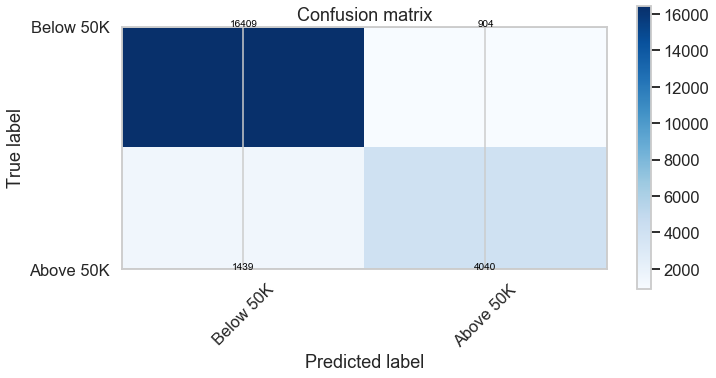

In [208]:
y_predknn_70_train = knn_def70.predict(x_train70)
cm_knn_train = confusion_matrix(y_train70, y_predknn_70_train)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm_knn_train, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_train70, y_predknn_70_train))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_train70, y_predknn_70_train))
print ('precision:', precision_score(y_train70, y_predknn_70_train))
print ('accuracy score:', knn_def70.score(x_train70, y_train70))
print ('recall:', recall_score(y_train70, y_predknn_70_train))
print ('f1:', f1_score(y_train70, y_predknn_70_train))

In [204]:
scoreKNN_train_70 = cross_val_score(knn_def70, x_train70, y_train70, cv=5, scoring= 'precision')
print(scoreKNN_train_70)
np.average(scoreKNN_train_70)

[0.73505976 0.74430642 0.70447761 0.7257085  0.70898438]


0.7237073336280455

Let's compare this to the test data.

Confusion Matrix, without normalization
[[16409   904]
 [ 1439  4040]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7407
           1       0.79      0.55      0.65      2362

    accuracy                           0.86      9769
   macro avg       0.83      0.75      0.78      9769
weighted avg       0.85      0.86      0.85      9769

roc_auc_score: 0.7532760449157473
precision: 0.7863145258103241
accuracy score: 0.8558706111167981
recall: 0.554614733276884
f1: 0.650446871896723


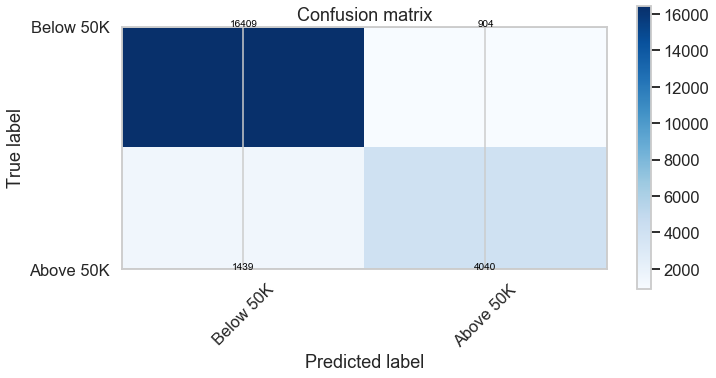

In [209]:
y_predknn_70 = knn_def70.predict(x_test70)
cm_knn_70 = confusion_matrix(y_test70, y_predknn_70)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm_knn_train, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_test70, y_predknn_70))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test70, y_predknn_70))
print ('precision:', precision_score(y_test70, y_predknn_70))
print ('accuracy score:', knn_def70.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_predknn_70))
print ('f1:', f1_score(y_test70, y_predknn_70))

In [206]:
scoreKNN_70 = cross_val_score(knn_def70, x_test70, y_test70, cv=5, scoring= 'precision')
print(scoreKNN_70)
np.average(scoreKNN_70)

[0.6784141  0.71190476 0.71232877 0.67268623 0.70561798]


0.6961903667441491

In [210]:
y_predknn_70_smt = knn_def70_smt.predict(x_test70)
print ('roc_auc_score:', roc_auc_score(y_test70, y_predknn_70_smt))
print ('precision:', precision_score(y_test70, y_predknn_70_smt))
print ('accuracy score:', knn_def70_smt.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_predknn_70_smt))
print ('f1:', f1_score(y_test70, y_predknn_70_smt))

y_predknn_80 = knn_def80.predict(x_test80)
print ('roc_auc_score:', roc_auc_score(y_test80, y_predknn_80))
print ('precision:', precision_score(y_test80, y_predknn_80))
print ('accuracy score:', knn_def80.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_predknn_80))
print ('f1:', f1_score(y_test80, y_predknn_80))

y_predknn_80_smt= knn_def80_smt.predict(x_test80)
print ('roc_auc_score:', roc_auc_score(y_test80, y_predknn_80_smt))
print ('precision:', precision_score(y_test80, y_predknn_80_smt))
print ('accuracy score:', knn_def80_smt.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_predknn_80_smt))
print ('f1:', f1_score(y_test80, y_predknn_80_smt))

roc_auc_score: 0.8036155811600967
precision: 0.6724752475247525
accuracy score: 0.8473743474255298
recall: 0.7188823031329382
f1: 0.6949048496009822
roc_auc_score: 0.7506824779040847
precision: 0.7727272727272727
accuracy score: 0.8509135575003839
recall: 0.5542319749216301
f1: 0.6454910551296094
roc_auc_score: 0.8050166938416999
precision: 0.6630620375640296
accuracy score: 0.8430830646399509
recall: 0.7304075235109718
f1: 0.6951073985680191


In [211]:
scoreKNN_70 = cross_val_score(knn_def70, x_test70, y_test70, cv=5, scoring= 'precision')
scoreKNN_70_smt = cross_val_score(knn_def70_smt, x_test70, y_test70, cv=5, scoring= 'precision')
scoreKNN_80 = cross_val_score(knn_def80, x_test80, y_test80, cv=5, scoring= 'precision')
scoreKNN_80_smt = cross_val_score(knn_def80_smt, x_test80, y_test80, cv=5, scoring= 'precision')
print(scoreKNN_70)
print(np.average(scoreKNN_70))
print(scoreKNN_70_smt)
print(np.average(scoreKNN_70_smt)
print(scoreKNN_80)
print(np.average(scoreKNN_80))
print(scoreKNN_80_smt)
print(np.average(scoreKNN_80_smt))

0.6961903667441491
0.6961903667441491
0.6965578650538313
0.6965578650538313


In [220]:
print(scoreKNN_70)
print(scoreKNN_70_smt)
print(scoreKNN_80)
print(scoreKNN_80_smt)

[0.6784141  0.71190476 0.71232877 0.67268623 0.70561798]
[0.6784141  0.71190476 0.71232877 0.67268623 0.70561798]
[0.67507886 0.70486111 0.71691176 0.70819672 0.67774086]
[0.67507886 0.70486111 0.71691176 0.70819672 0.67774086]


In [216]:
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    #Fit the model
    knn.fit(x_train70, y_train70)
    #Compute accuracy on the training set
    train_accuracy[i] = knn_def70.score(x_train70, y_train70)
    #Compute accuracy on the test set
    test_accuracy[i] = knn_def70.score(x_test70, y_test70)
    


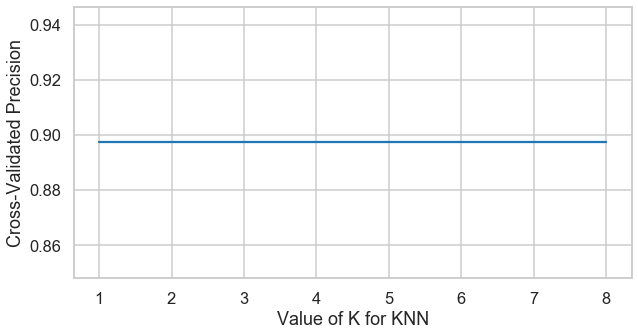

In [217]:
plt.plot(neighbors, train_accuracy)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Precision')
plt.show()

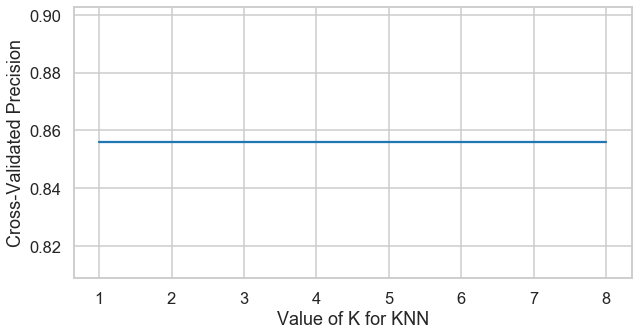

In [218]:
plt.plot(neighbors, test_accuracy)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Precision')
plt.show()

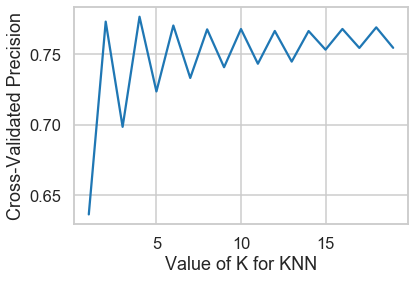

In [219]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 20
k_range = range(1, 20)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train70, y_train70, cv=5, scoring='precision')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Precision')
plt.show()

In [247]:
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors':np.arange(1,20)}, cv=5)

In [248]:
knn_grid.fit(x_train70,y_train70)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [249]:
knn_grid.best_params_

{'n_neighbors': 15}

### KNN Model with K=15

In [221]:
from sklearn.neighbors import KNeighborsClassifier
knn_def70 = KNeighborsClassifier(n_neighbors=15);
knn_def80 = KNeighborsClassifier(n_neighbors=15);
knn_def70_smt = KNeighborsClassifier(n_neighbors=15);
knn_def80_smt = KNeighborsClassifier(n_neighbors=15);

knn_def70.fit(x_train70, y_train70);
knn_def80.fit(x_train80, y_train80);
knn_def70_smt.fit(x_train70_smt, y_train70_smt);
knn_def80_smt.fit(x_train80_smt, y_train80_smt);

In [222]:
y_predknn_70 = knn_def70_smt.predict(x_test70)
print ('roc_auc_score:', roc_auc_score(y_test70, y_predknn_70_smt))
print ('precision:', precision_score(y_test70, y_predknn_70_smt))
print ('accuracy score:', knn_def70_smt.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_predknn_70_smt))
print ('f1:', f1_score(y_test70, y_predknn_70_smt))
print ('CV_5: ',np.average(cross_val_score(knn_def70, x_test70, y_test70, cv=5, scoring= 'precision')))

y_predknn_70_smt = knn_def70_smt.predict(x_test70)
print ('roc_auc_score:', roc_auc_score(y_test70, y_predknn_70_smt))
print ('precision:', precision_score(y_test70, y_predknn_70_smt))
print ('accuracy score:', knn_def70_smt.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_predknn_70_smt))
print ('f1:', f1_score(y_test70, y_predknn_70_smt))
print ('CV_5: ',np.average(cross_val_score(knn_def70_smt, x_test70, y_test70, cv=5, scoring= 'precision')))

y_predknn_80 = knn_def80.predict(x_test80)
print ('roc_auc_score:', roc_auc_score(y_test80, y_predknn_80))
print ('precision:', precision_score(y_test80, y_predknn_80))
print ('accuracy score:', knn_def80.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_predknn_80))
print ('f1:', f1_score(y_test80, y_predknn_80))
print ('CV_5: ',np.average(cross_val_score(knn_def80, x_test80, y_test80, cv=5, scoring= 'precision')))

y_predknn_80_smt= knn_def80_smt.predict(x_test80)
print ('roc_auc_score:', roc_auc_score(y_test80, y_predknn_80_smt))
print ('precision:', precision_score(y_test80, y_predknn_80_smt))
print ('accuracy score:', knn_def80_smt.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_predknn_80_smt))
print ('f1:', f1_score(y_test80, y_predknn_80_smt))
print ('CV_5: ',np.average(cross_val_score(knn_def80_smt, x_test80, y_test80, cv=5, scoring= 'precision')))

roc_auc_score: 0.8036155811600967
precision: 0.6724752475247525
accuracy score: 0.8397993653393387
recall: 0.7188823031329382
f1: 0.6949048496009822
CV_5:  0.7234422671331429
roc_auc_score: 0.8146244307196421
precision: 0.641261963842609
accuracy score: 0.8397993653393387
recall: 0.7658763759525825
f1: 0.6980513216284006
CV_5:  0.7234422671331429
roc_auc_score: 0.7423539782846202
precision: 0.809477756286267
accuracy score: 0.8533701827115001
recall: 0.5247648902821317
f1: 0.6367440091289465
CV_5:  0.7110681530700045
roc_auc_score: 0.8190302146423923
precision: 0.6482939632545932
accuracy score: 0.8418547520343928
recall: 0.774294670846395
f1: 0.7057142857142857
CV_5:  0.7110681530700045


In [309]:
feature_scores_70 = pd.Series(knn_def70.feature_importances_, index=x_train70.columns).sort_values(ascending=False)
feature_scores_70_smt = pd.Series(knn_def70_smt.feature_importances_, index=x_train70_smt.columns).sort_values(ascending=False)
feature_scores_80 = pd.Series(knn_def80.feature_importances_, index=x_train80.columns).sort_values(ascending=False)
feature_scores_80_smt = pd.Series(knn_def80_smt.feature_importances_, index=x_train80_smt.columns).sort_values(ascending=False)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

# Model 4 Decision Tree




In [295]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [263]:
#creating a confusion matrix template
import warnings
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 5]

# from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [264]:
#Get training data + test data

#X train
x_train70_smt = pd.read_csv('x_train70_smt.csv').drop(columns=['Unnamed: 0'])
x_train80_smt = pd.read_csv('x_train80_smt.csv').drop(columns=['Unnamed: 0'])
x_test70 = pd.read_csv('x_test70.csv').drop(columns=['Unnamed: 0'])
x_test80 = pd.read_csv('x_test80.csv').drop(columns=['Unnamed: 0'])

#Y Train
y_train70_smt =pickle.load(open('y_train70_smt.pickle', 'rb'))
y_train80_smt =pickle.load(open('y_train80_smt.pickle', 'rb'))
y_test70 = pickle.load(open('y_test70.pickle', 'rb'))
y_test80 = pickle.load(open('y_test80.pickle', 'rb'))

In [265]:
list(enumerate(x_train70_smt.columns.tolist()));
categoricals = list(range(5, len(x_train70_smt.columns)))

In [266]:
tree_def70_smt = DecisionTreeClassifier();
tree_def80_smt = DecisionTreeClassifier();

tree_def70_smt.fit(x_train70_smt, y_train70_smt);
tree_def80_smt.fit(x_train80_smt, y_train80_smt);

In [267]:
features_70 = x_train70_smt.columns.tolist()
features_80 = x_train80_smt.columns.tolist()

In [268]:
r_70_smt = export_text(tree_def70_smt, feature_names= features_70)
print(r_70_smt)

|--- marital_status_ Married-civ-spouse <= -0.50
|   |--- capital_gain <= 7073.50
|   |   |--- education_num <= 0.62
|   |   |   |--- marital_status_ Never-married <= 0.50
|   |   |   |   |--- sex_ Female <= 0.50
|   |   |   |   |   |--- sex_ Male <= -0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sex_ Male >  -0.50
|   |   |   |   |   |   |--- marital_status_ Divorced <= 0.50
|   |   |   |   |   |   |   |--- marital_status_ Separated <= 0.50
|   |   |   |   |   |   |   |   |--- marital_status_ Married-spouse-absent <= 0.50
|   |   |   |   |   |   |   |   |   |--- marital_status_ Widowed <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- relationship_ Husband <= -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- relationship_ Husband >  -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- marital_status_ Widowed >  0.50
|   |   |   |   |   |   |   |   |  

In [269]:
tree_def70_smt.tree_.node_count

9157

In [270]:
r_80_smt = export_text(tree_def70_smt, feature_names= features_70)
print(r_80_smt)

|--- marital_status_ Married-civ-spouse <= -0.50
|   |--- capital_gain <= 7073.50
|   |   |--- education_num <= 0.62
|   |   |   |--- marital_status_ Never-married <= 0.50
|   |   |   |   |--- sex_ Female <= 0.50
|   |   |   |   |   |--- sex_ Male <= -0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sex_ Male >  -0.50
|   |   |   |   |   |   |--- marital_status_ Divorced <= 0.50
|   |   |   |   |   |   |   |--- marital_status_ Separated <= 0.50
|   |   |   |   |   |   |   |   |--- marital_status_ Married-spouse-absent <= 0.50
|   |   |   |   |   |   |   |   |   |--- marital_status_ Widowed <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- relationship_ Husband <= -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- relationship_ Husband >  -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- marital_status_ Widowed >  0.50
|   |   |   |   |   |   |   |   |  

In [271]:
tree_def80_smt.tree_.node_count

10199

In [274]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(tree_def70_smt, out_file=None, 
                     feature_names=features_70,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("IncomeClassification_DTree_SMOTE70")

'IncomeClassification_DTree_SMOTE70.pdf'

In [275]:
dot_data2 = tree.export_graphviz(tree_def80_smt, out_file=None, 
                     feature_names=features_80,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data2)  
graph.render("IncomeClassification_DTree_SMOTE80")

'IncomeClassification_DTree_SMOTE80.pdf'

In [277]:
y_DTpred_sm70train = tree_def70_smt.predict(x_train70_smt)
y_DTpred_sm80train = tree_def80_smt.predict(x_train80_smt)

In [278]:
print ('accuracy score:', tree_def70_smt.score(x_train70_smt, y_train70_smt))
print ('recall:', recall_score(y_train70_smt, y_DTpred_sm70train))
print ('precision:', precision_score(y_train70_smt, y_DTpred_sm70train))
print ('f1:', f1_score(y_train70_smt, y_DTpred_sm70train))

accuracy score: 0.9769537341881823
recall: 0.9761450932825044
precision: 0.9777263523286086
f1: 0.9769350829527719


In [280]:
print ('accuracy score:', tree_def80_smt.score(x_train80_smt, y_train80_smt))
print ('recall:', recall_score(y_train80_smt, y_DTpred_sm80train))
print ('precision:', precision_score(y_train80_smt, y_DTpred_sm80train))
print ('f1:', f1_score(y_train80_smt, y_DTpred_sm80train))

accuracy score: 0.9758357741642258
recall: 0.9772750227249772
precision: 0.9744700135958507
f1: 0.9758705025087617


## Hyperparameter with Gridsearch
- best value for max_dept is 11, with a 0.83 accuracy

In [282]:
tree_clf_70_smt = DecisionTreeClassifier()
tree_clf_80_smt = DecisionTreeClassifier()

max_depth_params = range(2, 12)

max_features_param = [None, 'auto', 'sqrt', 'log2']

param_grid = {'max_depth': max_depth_params, 'max_features': max_features_param}

gridsearch_70_smt = GridSearchCV(estimator = tree_clf_70_smt, 
                          param_grid = param_grid,
                          n_jobs = -1, #parallel computation
                          verbose = 1, #give feedback
                          cv = 10, #cross-validate 10 times
                          scoring = 'precision', #can use multiple scoring  , recall, precision..ect
                          return_train_score= True)

gridsearch_80_smt = GridSearchCV(estimator = tree_clf_80_smt, 
                          param_grid = param_grid,
                          n_jobs = -1, #parallel computation
                          verbose = 1, #give feedback
                          cv = 10, #cross-validate 10 times
                          scoring = 'precision', #can use multiple scoring  , recall, precision..ect
                          return_train_score= True)

gridsearch_70_smt = gridsearch_70_smt.fit(x_train70_smt, y_train70_smt)
gridsearch_80_smt = gridsearch_80_smt.fit(x_train80_smt, y_train80_smt)



Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.1s finished


In [283]:
print(gridsearch_70_smt.best_estimator_)
print(gridsearch_70_smt.best_score_)

print(gridsearch_80_smt.best_estimator_)
print(gridsearch_80_smt.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8306490277538074
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8377035922673063


Best Max depth is 11!

In [284]:
columns = ['params', 'mean_test_score', 
          'std_test_score', 'rank_test_score',
          'mean_train_score', 'std_train_score']

log_reg_results = pd.DataFrame(gridsearch_70_smt.cv_results_)[columns]
log_reg_results.sort_values(by = 'rank_test_score').head(5)

,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
36,"{'max_depth': 11, 'max_features': None}",0.830649,0.004958,1,0.849984,0.006823
32,"{'max_depth': 10, 'max_features': None}",0.830103,0.009720,2,0.845828,0.006553
20,"{'max_depth': 7, 'max_features': None}",0.825140,0.013840,3,0.830137,0.006744
28,"{'max_depth': 9, 'max_features': None}",0.821205,0.011496,4,0.832346,0.007196
24,"{'max_depth': 8, 'max_features': None}",0.819328,0.014973,5,0.827388,0.012845


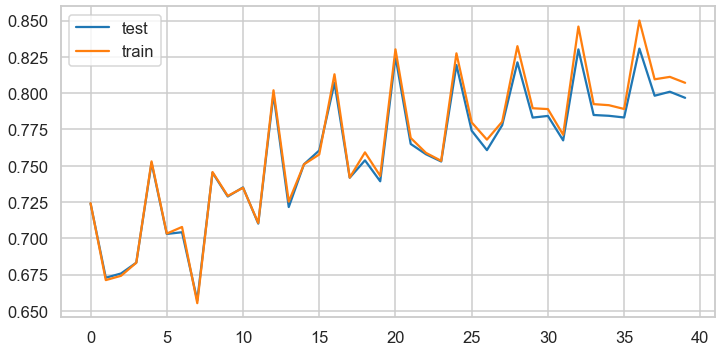

In [286]:
roc_test_scores = gridsearch_70_smt.cv_results_['mean_test_score']

roc_training_scores = gridsearch_70_smt.cv_results_['mean_train_score']

plt.plot(range(40), roc_test_scores, label = 'test')
plt.plot(range(40), roc_training_scores, label = 'train')


plt.legend()
plt.tight_layout()

### Decision Tree with Max_dept=11

In [288]:
tuned_tree_def70_smt = DecisionTreeClassifier(max_depth=11)
tuned_tree_def80_smt = DecisionTreeClassifier(max_depth=11)

tuned_tree_def70_smt.fit(x_train70_smt, y_train70_smt);
tuned_tree_def80_smt.fit(x_train80_smt, y_train80_smt);

print(tuned_tree_def70_smt.tree_.node_count)
print(tuned_tree_def80_smt.tree_.node_count)

945
941


In [290]:
tuned_dot_data_70 = tree.export_graphviz(tuned_tree_def70_smt, out_file=None, 
                     feature_names=features_70,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(tuned_dot_data_70)  
graph.render("IncomeClassification_Tuned_DTree_SMOTE70")

'IncomeClassification_Tuned_DTree_SMOTE70.pdf'

In [291]:
tuned_dot_data_80 = tree.export_graphviz(tuned_tree_def80_smt, out_file=None, 
                     feature_names=features_70,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(tuned_dot_data_80)  
graph.render("IncomeClassification_Tuned_DTree_SMOTE80")

'IncomeClassification_Tuned_DTree_SMOTE80.pdf'

In [292]:
y_tunedDTpred_sm70train = tuned_tree_def70_smt.predict(x_train70_smt)
y_tunedDTpred_sm80train = tuned_tree_def80_smt.predict(x_train80_smt)

In [293]:
print ('accuracy score:', tuned_tree_def70_smt.score(x_train70_smt, y_train70_smt))
print ('recall:', recall_score(y_train70_smt, y_tunedDTpred_sm70train))
print ('precision:', precision_score(y_train70_smt, y_tunedDTpred_sm70train))
print ('f1:', f1_score(y_train70_smt, y_tunedDTpred_sm70train))

accuracy score: 0.8791370646335124
recall: 0.9102408594697626
precision: 0.8569331158238173
f1: 0.8827829594151753


In [294]:
print ('accuracy score:', tuned_tree_def80_smt.score(x_train80_smt, y_train80_smt))
print ('recall:', recall_score(y_train80_smt, y_tunedDTpred_sm80train))
print ('precision:', precision_score(y_train80_smt, y_tunedDTpred_sm80train))
print ('f1:', f1_score(y_train80_smt, y_tunedDTpred_sm80train))

accuracy score: 0.876982123017877
recall: 0.9172305827694173
precision: 0.8488969900916059
f1: 0.8817418321277734


In [296]:
scores_tree_70 = cross_val_score(tuned_tree_def70_smt, x_train70_smt, y_train70_smt, cv=5, scoring= 'precision')
print(scores_tree_70)
print(np.average(scores_tree_70))

[0.83007145 0.83073062 0.81557178 0.8241594  0.83148335]
0.8264033196767915


In [297]:
scores_tree_80 = cross_val_score(tuned_tree_def80_smt, x_train80_smt, y_train80_smt, cv=5, scoring= 'precision')
print(scores_tree_80)
print(np.average(scores_tree_80))

[0.83621399 0.83499878 0.82614379 0.82631695 0.83042614]
0.8308199312322323


Now let's fit our test data!

In [298]:
y_tunedDTpred_sm70 = tuned_tree_def70_smt.predict(x_test70)
y_tunedDTpred_sm80 = tuned_tree_def80_smt.predict(x_test80)

In [301]:
print ('roc_auc_score:', roc_auc_score(y_test70, y_tunedDTpred_sm70))
print ('accuracy score:', tuned_tree_def70_smt.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_tunedDTpred_sm70))
print ('precision:', precision_score(y_test70, y_tunedDTpred_sm70))
print ('f1:', f1_score(y_test70, y_tunedDTpred_sm70))

roc_auc_score: 0.8004171569402448
accuracy score: 0.8125703756781656
recall: 0.7768839966130398
precision: 0.5845810767760433
f1: 0.6671514270132702


In [302]:
print ('roc_auc_score:', roc_auc_score(y_test80, y_tunedDTpred_sm80))
print ('accuracy score:', tuned_tree_def70_smt.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_tunedDTpred_sm80))
print ('precision:', precision_score(y_test80, y_tunedDTpred_sm80))
print ('f1:', f1_score(y_test80, y_tunedDTpred_sm80))

roc_auc_score: 0.8028398653274198
accuracy score: 0.8083832335329342
recall: 0.7949843260188088
precision: 0.5766257389722601
f1: 0.6684238270954137


In [305]:
scores_tree_70_test = cross_val_score(tuned_tree_def70_smt, x_test70, y_test70, cv=5, scoring= 'precision')
print(scores_tree_70_test)
print(np.average(scores_tree_70_test))

[0.69845361 0.68       0.69536424 0.74018127 0.72222222]
0.7072442675524833


In [304]:
scores_tree_80_test = cross_val_score(tuned_tree_def80_smt, x_test80, y_test80, cv=5, scoring= 'precision')
print(scores_tree_80_test)
print(np.average(scores_tree_80_test))

[0.71875    0.71825397 0.69879518 0.7245283  0.71666667]
0.7153988235060638


## LogReg w/ SMOTE

In [311]:
logreg_sm_70 = LogisticRegression(solver = 'lbfgs', max_iter=10000)
logreg_sm_80 = LogisticRegression(solver = 'lbfgs', max_iter=10000)

logreg_sm_70.fit(x_train70_smt, y_train70_smt)
logreg_sm_80.fit(x_train70_smt, y_train70_smt)

print(logreg_sm_70.score(x_train70_smt, y_train70_smt))
print(logreg_sm_80.score(x_train80_smt, y_train80_smt))


0.8747761797493213
0.8739773760226239


Confusion Matrix, without normalization
[[6507  900]
 [ 676 1686]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7407
           1       0.65      0.71      0.68      2362

    accuracy                           0.84      9769
   macro avg       0.78      0.80      0.79      9769
weighted avg       0.84      0.84      0.84      9769

roc_auc_score: 0.796147589980277
precision: 0.6519721577726219
accuracy score: 0.8386733544886887
recall: 0.7138018628281118
f1: 0.6814874696847211


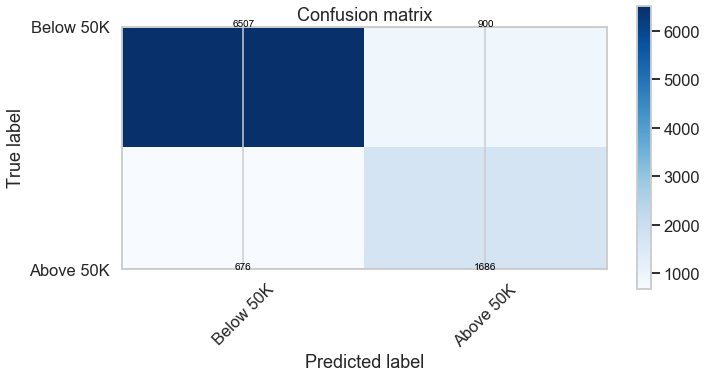

In [314]:
y_predlog_70_smt = logreg_sm_70.predict(x_test70)
cm_log_70_smt = confusion_matrix(y_test70, y_predlog_70_smt)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm_log_70_smt, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_test70, y_predlog_70_smt))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test70, y_predlog_70_smt))
print ('precision:', precision_score(y_test70, y_predlog_70_smt))
print ('accuracy score:', logreg_sm_70.score(x_test70, y_test70))
print ('recall:', recall_score(y_test70, y_predlog_70_smt))
print ('f1:', f1_score(y_test70, y_predlog_70_smt))

In [313]:
scores_log_70_test = cross_val_score(logreg_sm_70, x_test80, y_test80, cv=5, scoring= 'precision')
print(scores_log_70_test)
print(np.average(scores_log_70_test))

[0.74509804 0.72932331 0.71084337 0.76377953 0.70542636]
0.7308941210257082


Confusion Matrix, without normalization
[[4292  626]
 [ 464 1131]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4918
           1       0.64      0.71      0.67      1595

    accuracy                           0.83      6513
   macro avg       0.77      0.79      0.78      6513
weighted avg       0.84      0.83      0.84      6513

roc_auc_score: 0.7909016969204037
precision: 0.6437108708025042
accuracy score: 0.8326424074927069
recall: 0.7090909090909091
f1: 0.6748210023866349


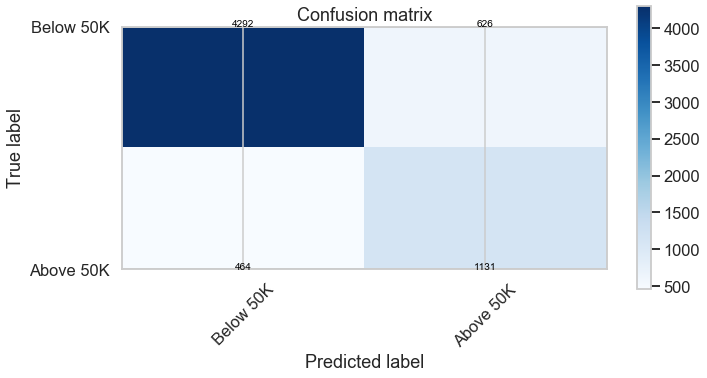

In [315]:
y_predlog_80_smt = logreg_sm_80.predict(x_test80)
cm_log_80_smt = confusion_matrix(y_test80, y_predlog_80_smt)
classes = ['Below 50K', 'Above 50K']
plot_confusion_matrix(cm_log_80_smt, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_test80, y_predlog_80_smt))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_test80, y_predlog_80_smt))
print ('precision:', precision_score(y_test80, y_predlog_80_smt))
print ('accuracy score:', logreg_sm_80.score(x_test80, y_test80))
print ('recall:', recall_score(y_test80, y_predlog_80_smt))
print ('f1:', f1_score(y_test80, y_predlog_80_smt))

### Brief Detour into Logistic Regression with Stratified KFold

The logistic model alternatively suggests that marital status is a much more important feature than in some of the other models.

Optimal number of features: 40


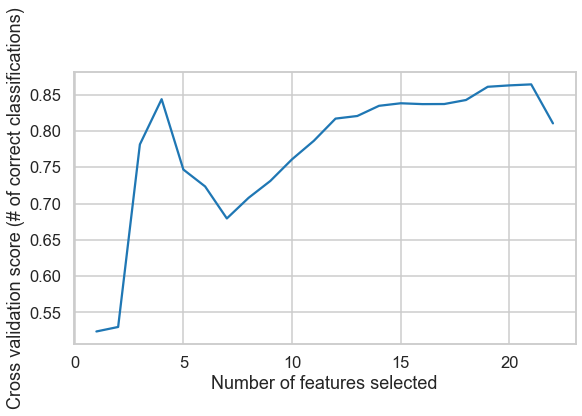

In [310]:
from sklearn.model_selection import StratifiedKFold
logreg = LogisticRegression()
#from sklearn.model_selection import KFold

rfecv = RFECV(estimator=logreg, step=2, cv=StratifiedKFold(5), scoring="precision")
#rfecv = RFECV(estimator=logreg, step=1, cv=KFold(10), scoring="accuracy")

rfecv.fit(x_train70_smt, y_train70_smt)

print("Optimal number of features: {}".format(rfecv.n_features_))

# Plotting the best number of features with respect to the Cross Validation Score:
plt.figure(figsize=(9,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

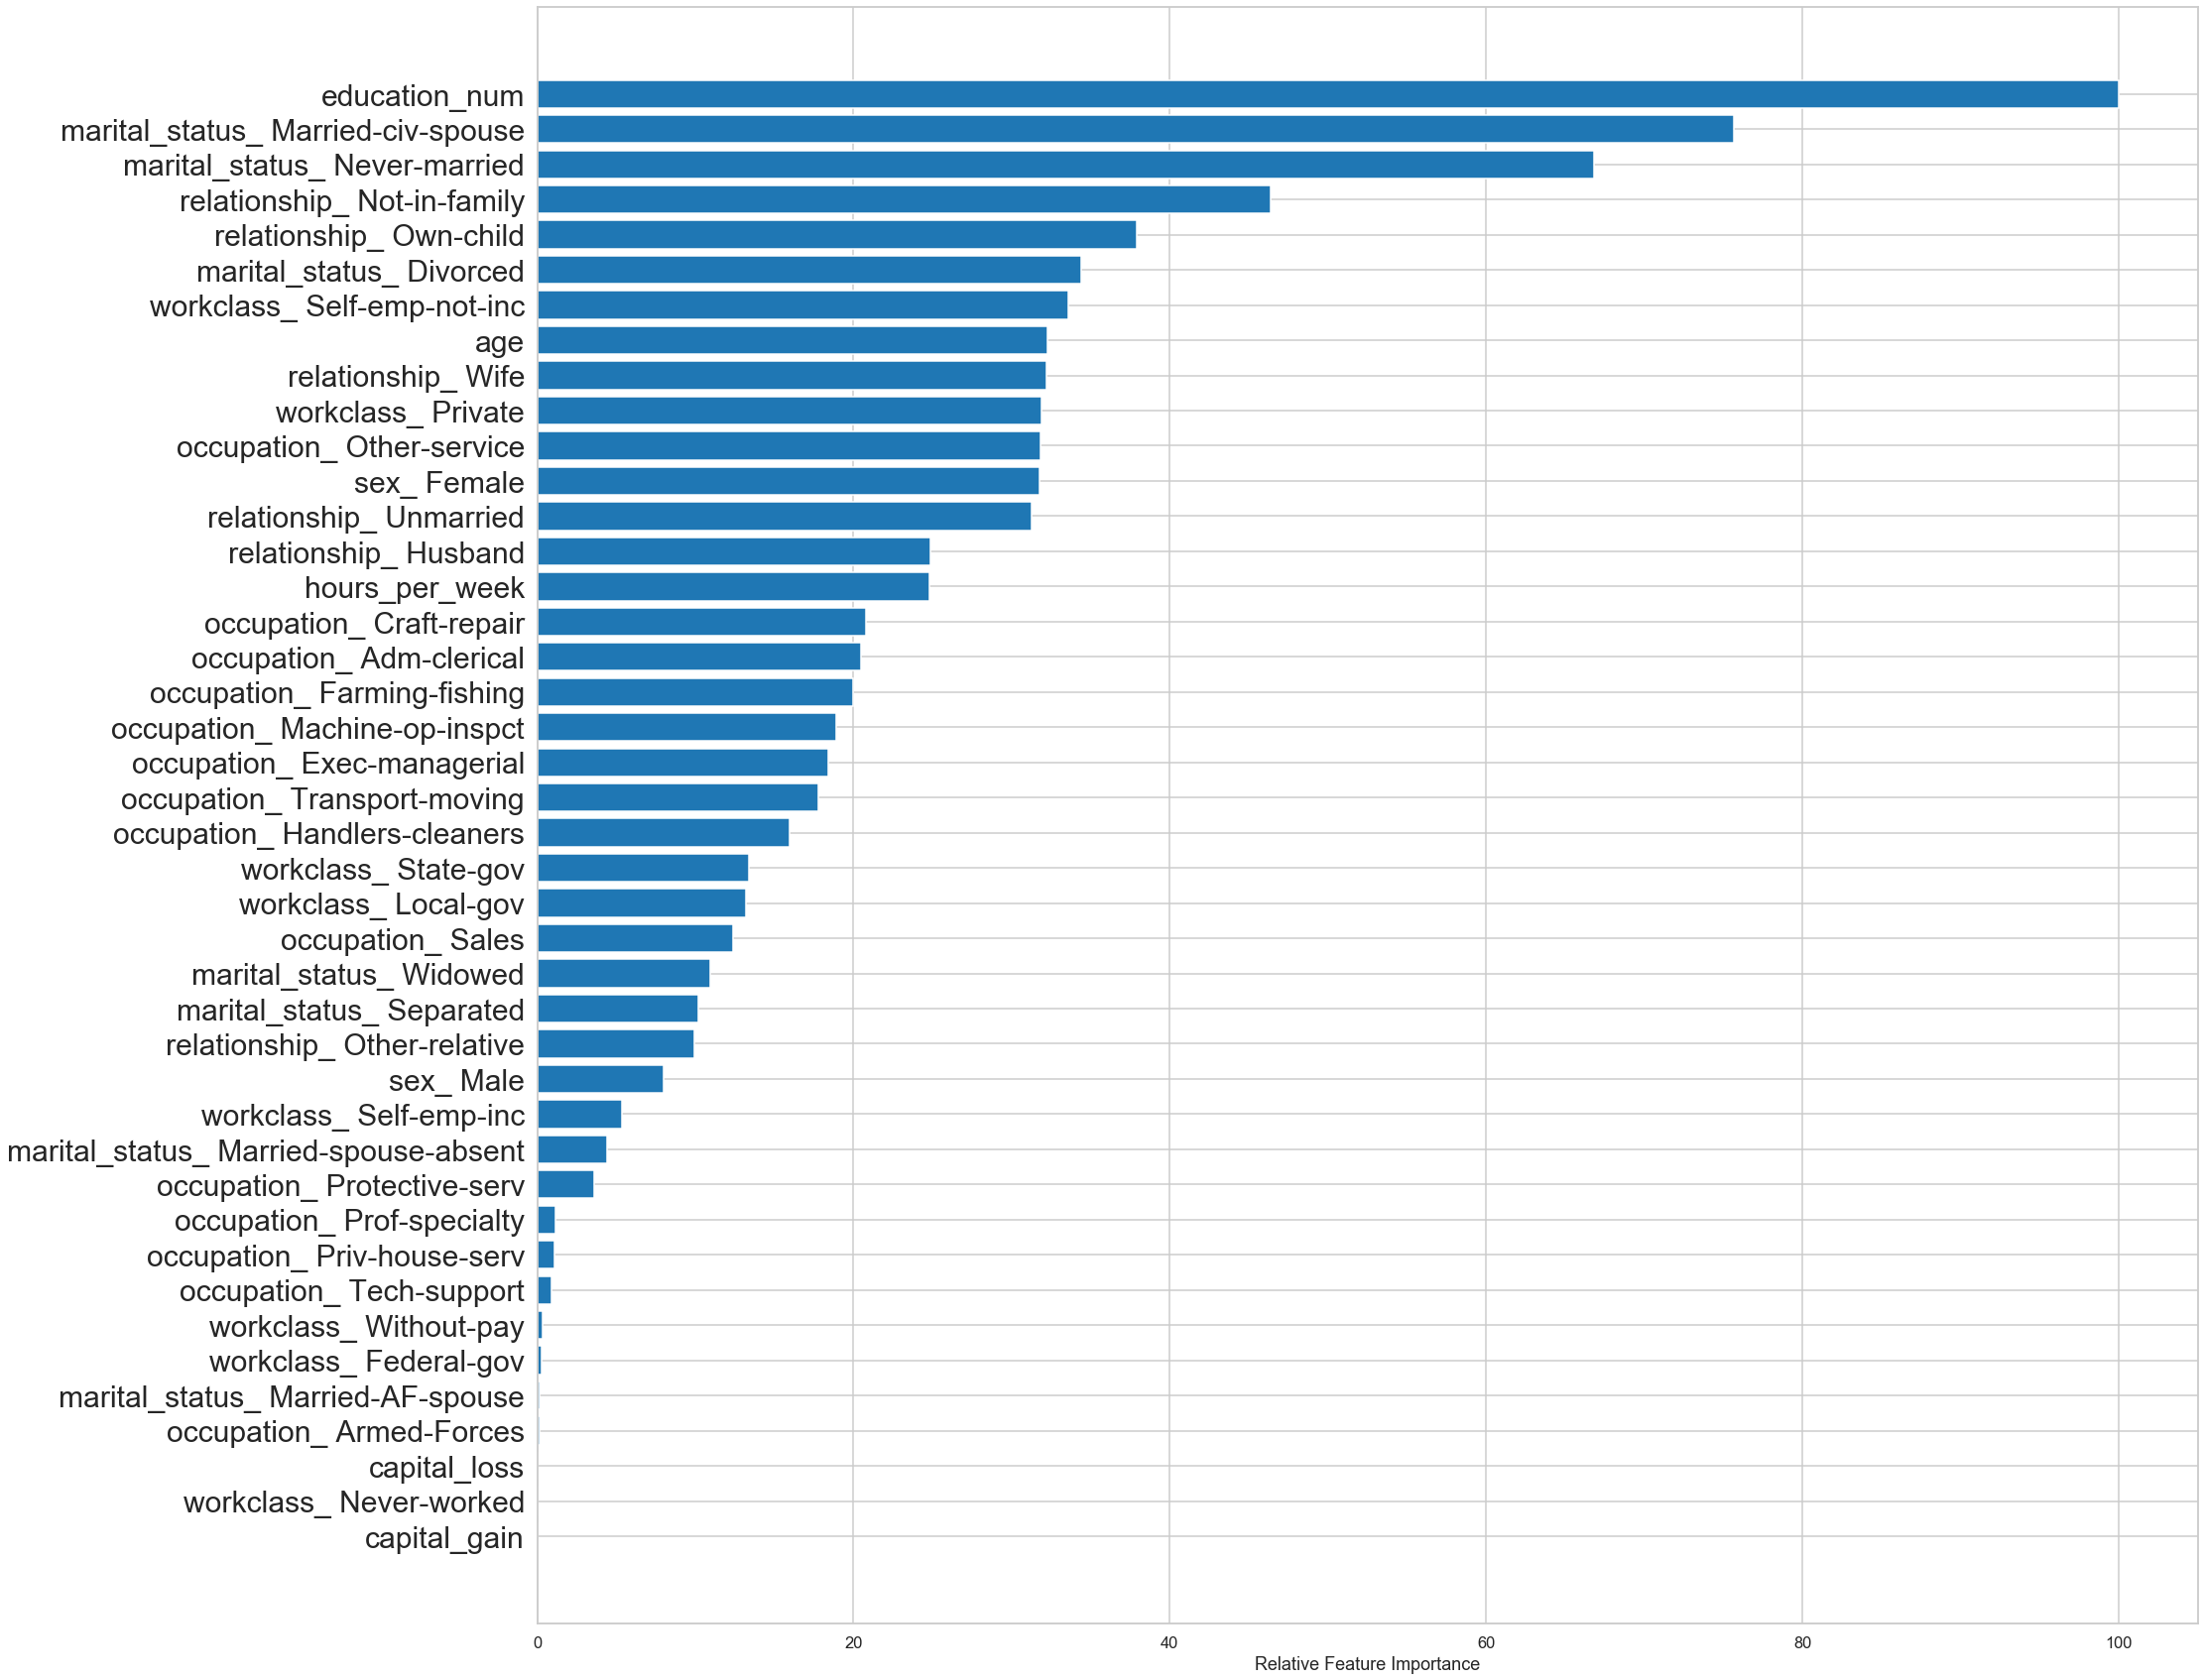

In [308]:
logreg = LogisticRegression(random_state=10, solver= "liblinear")
model = logreg.fit(x_train70_smt, y_train70_smt)
coefs = logreg.coef_.T
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(30,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_train70_smt.columns)[sorted_idx], fontsize=30)
featax.set_xlabel('Relative Feature Importance')
 
plt.tight_layout
plt.show()

## Results and Conclusion 

1. In this project, I built a  various models (Random Forest Classifier, KNN model, Decision Tree) to predict the income of a person. The best model performance achieved in terms of F1 score is 0.70 with the KNN model with 15 neighbors. 

2. I dealt with the class imbalance in my data using SMOTE and also experimented with changing the test/train split. Adjusting for class imbalance improved the recall of all of my models while in turn improved the F1 score.

3. I have used the Random Forest model to find only the important features, build the model using these features and see its effect on accuracy. We learned the features by their importance as well as the difference the split (70/30 or 80/20) and SMOTE had on reranking the feature selection.

4. Confusion matrix and classification report are another tool to visualize the model performance. They yield good performance.

Finally, the candidate income profile heavily influenced from our random forest model:
- Age → focus on citizens < 36
- Marital Status → focus on single
- Education → focus on education < 10th grade (those who don’t have a high school diploma) 

*Workclass/occupation did not rank high for the 1994 data set as an income determinant
- Does not provide accurate representation of factors that would be relevant to today’s job market
